In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

In [2]:
train_path = 'datasets/aerolineas/train.csv'
test_path = 'datasets/aerolineas/test.csv'
comparacion = {}

def load_dataset(path):
    df = pd.read_csv(path)
    df.drop(columns=[df.columns[0]], inplace=True)
    df.drop(columns=[df.columns[0]], inplace=True)
    df = df[df['Arrival Delay in Minutes'].notnull()]
    return df

train = load_dataset(train_path) 
test = load_dataset(test_path)

In [3]:
# preprocesamiento

for colname in ['Gender', 'Customer Type', 'Type of Travel', 'Class']:
    print(f'{colname} uniques: {train[colname].unique()}')

train = pd.get_dummies(
    train,
    columns=train.select_dtypes(include='object').columns,
    drop_first=True,
    dtype=int,
)
test = pd.get_dummies(
    test,
    columns=test.select_dtypes(include='object').columns,
    drop_first=True,
    dtype=int,
)

y_train = train['satisfaction_satisfied']
x_train = train.drop(columns=['satisfaction_satisfied'])
y_test = test['satisfaction_satisfied']
x_test = test.drop(columns=['satisfaction_satisfied'])

scale_cols = [col for col in list(x_train.columns) if "_" not in col]
scale_standr_cols = [
    "Age",
    "Flight Distance",
    "Departure Delay in Minutes",
    "Arrival Delay in Minutes",
]
scale_minmax_cols = [col for col in scale_cols if col not in scale_standr_cols]

print(f'Train Y: {y_train.shape}\nTrain X: {x_train.shape}')
print(f'Test Y: {y_test.shape}\nTest X: {x_test.shape}')

Gender uniques: ['Male' 'Female']
Customer Type uniques: ['Loyal Customer' 'disloyal Customer']
Type of Travel uniques: ['Personal Travel' 'Business travel']
Class uniques: ['Eco Plus' 'Business' 'Eco']
Train Y: (103594,)
Train X: (103594, 23)
Test Y: (25893,)
Test X: (25893, 23)


In [4]:
def metricas(y_test, y_pred):
    print("Accuracy:", accuracy_score(y_test, y_pred))
    clas_rep = classification_report(y_test, y_pred)
    print("\nClassification report:\n", clas_rep)
    print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(
        cm, display_labels=['neutral or dissatisfied', 'satisfied']
    )
    disp.plot(values_format="d")
    plt.show()

Accuracy: 0.8265168192175492

Classification report:
               precision    recall  f1-score   support

           0       0.83      0.87      0.85     14528
           1       0.82      0.77      0.80     11365

    accuracy                           0.83     25893
   macro avg       0.83      0.82      0.82     25893
weighted avg       0.83      0.83      0.83     25893


Confusion matrix:
 [[12660  1868]
 [ 2624  8741]]


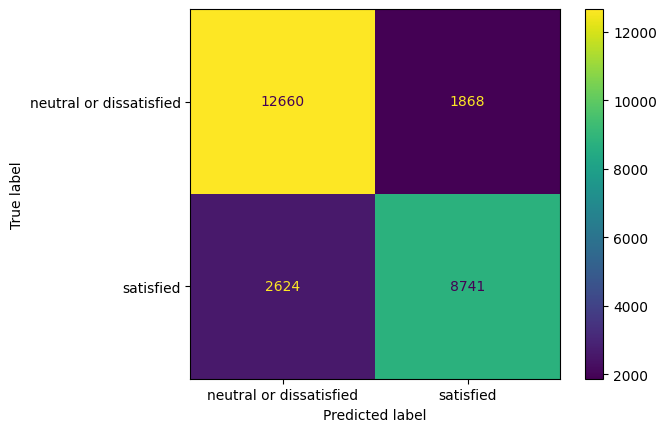

In [5]:
preprocessor = ColumnTransformer(
    transformers=[
        ('ssc', StandardScaler(), scale_standr_cols),
        ('smn', MinMaxScaler(), scale_minmax_cols)
    ]
)

logreg = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('regressor', LogisticRegressionCV(cv=10, random_state=42)),
    ]
)

logreg.fit(x_train, y_train)

best_threshold = 0.51374
y_proba = logreg.predict_proba(x_test)[:, 1]
y_pred = (y_proba >= best_threshold).astype(int)

comparacion['LogisticRegressionCV'] = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).T
metricas(y_test,y_pred)

Accuracy: 0.9127563434132777

Classification report:
               precision    recall  f1-score   support

           0       0.91      0.93      0.92     14528
           1       0.91      0.89      0.90     11365

    accuracy                           0.91     25893
   macro avg       0.91      0.91      0.91     25893
weighted avg       0.91      0.91      0.91     25893


Confusion matrix:
 [[13562   966]
 [ 1293 10072]]


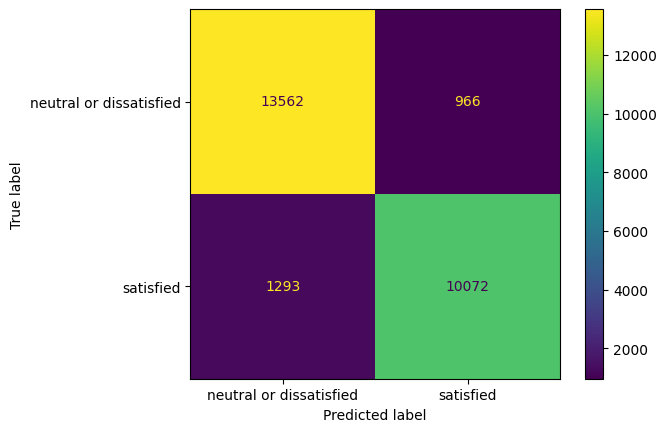

In [6]:
preprocessor = ColumnTransformer(
    transformers=[
        ('ssc', StandardScaler(), scale_standr_cols),
        ('smn', MinMaxScaler(), scale_minmax_cols)
    ]
)

params = {
    'n_neighbors': 9,
    'weights': 'uniform',
    'p': 1.0789835506466046
}
model = KNeighborsClassifier(**params)

knncls = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('cls', model),
    ]
)

knncls.fit(x_train, y_train)
y_pred = knncls.predict(x_test)

comparacion['KNeighborsClassifier'] = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).T
metricas(y_test,y_pred)

Accuracy: 0.9631946858224231

Classification report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97     14528
           1       0.97      0.94      0.96     11365

    accuracy                           0.96     25893
   macro avg       0.96      0.96      0.96     25893
weighted avg       0.96      0.96      0.96     25893


Confusion matrix:
 [[14245   283]
 [  670 10695]]


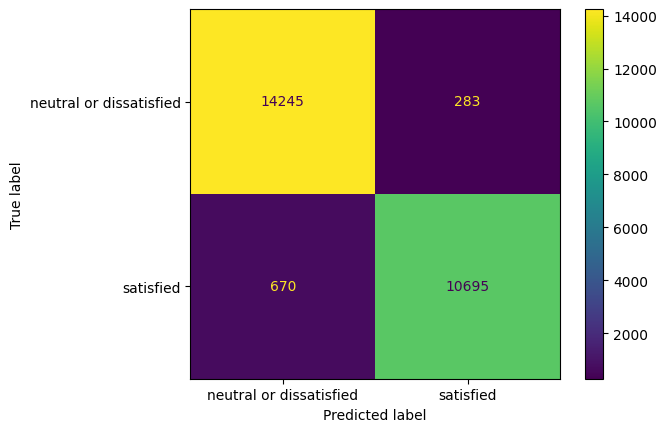

In [7]:
params = {
    'n_estimators': 391,
    'criterion': 'entropy',
    'max_depth': 28,
    'min_samples_split': 2,
    'min_samples_leaf': 1
}

rfc = RandomForestClassifier(
        **params,
        random_state=42,
    )

rfc.fit(x_train, y_train)
y_pred = rfc.predict(x_test)

comparacion['RandomForestClassifier'] = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).T
metricas(y_test,y_pred)

Accuracy: 0.9591781562584483

Classification report:
               precision    recall  f1-score   support

           0       0.96      0.97      0.96     14528
           1       0.96      0.94      0.95     11365

    accuracy                           0.96     25893
   macro avg       0.96      0.96      0.96     25893
weighted avg       0.96      0.96      0.96     25893


Confusion matrix:
 [[14103   425]
 [  632 10733]]


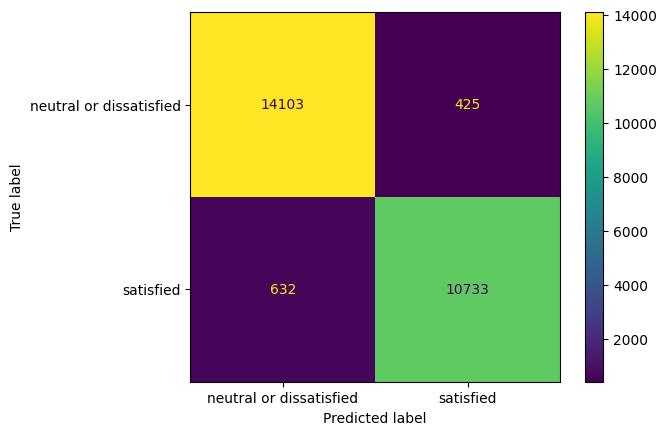

In [8]:
matrix_train = xgb.DMatrix(x_train, label=y_train)
matrix_valid = xgb.DMatrix(x_test, label=y_test)

xgb_params = {
    'max_depth': 10,
    'grow_policy': 'lossguide',
    'eta': 0.6052554699164627,
    'gamma': 4.271591606556778e-07,
    'min_child_weight': 3,
    'subsample': 0.9498368805345292,
    'colsample_bytree': 0.7535477648043124,
    'alpha': 0.07253417521624893,
    'lambda': 1.0206168463789922e-07,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss'
}
evals = [(matrix_train, "train"), (matrix_valid, "valid")]

boost = xgb.train(
    params=xgb_params,
    num_boost_round= 193,
    dtrain=matrix_train,
    evals=evals,
    #early_stopping_rounds=20,
    verbose_eval=False
)

y_proba = boost.predict(matrix_valid)
y_pred = (y_proba >= 0.5).astype(int)

comparacion['xgb'] = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).T
metricas(y_test,y_pred)

In [9]:
comparacion

{'LogisticRegressionCV':               precision    recall  f1-score       support
 0              0.828317  0.871421  0.849322  14528.000000
 1              0.823923  0.769116  0.795577  11365.000000
 accuracy       0.826517  0.826517  0.826517      0.826517
 macro avg      0.826120  0.820268  0.822450  25893.000000
 weighted avg   0.826389  0.826517  0.825732  25893.000000,
 'KNeighborsClassifier':               precision    recall  f1-score       support
 0              0.912959  0.933508  0.923119  14528.000000
 1              0.912484  0.886230  0.899165  11365.000000
 accuracy       0.912756  0.912756  0.912756      0.912756
 macro avg      0.912721  0.909869  0.911142  25893.000000
 weighted avg   0.912750  0.912756  0.912605  25893.000000,
 'RandomForestClassifier':               precision    recall  f1-score       support
 0              0.955079  0.980520  0.967632  14528.000000
 1              0.974221  0.941047  0.957347  11365.000000
 accuracy       0.963195  0.963195  0.9